In [8]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import pylab
import collections
import pymongo
import psycopg2
import paho.mqtt.client as mqtt
import seaborn as sns
from IPython import display
from pandas import datetime
from datetime import timedelta
from pymongo import MongoClient
from scipy import stats

import plotly.graph_objects as go
import plotly as py

py.offline.init_notebook_mode(connected=True)

In [9]:
# Set up MongoDB Client
client_mqtt = mqtt.Client()

# Set up NodeMCU Client
client_mongo = MongoClient('192.168.1.5')
temp_database = client_mongo['temp_collect']
data_1=temp_database['Temperature_1']
data_2=temp_database['Temperature_2']

--Zonal analysis done outside the room (in open)--
Date - 12:30pm 22/07/2019
Current temp - 19

we would like to take the temperature of the zones after 12:30 and see how they vary - most likely come up with an accurate co-integration test
And what it actually means by having two zones co-integrated(same or different) 

In [24]:
#Time : 2pm - 3pm , AC Temperature : 26, Date : 18/7/19
def create_df(date_req, start_time, end_time, data_1, data_2):
    """
    This function creates a dataframe containing all temperatures together for a particular time stamp
    """
    date_a=[]
    time_a=[]
    tmp_1=[]
    tmp_2=[]
    tmp_3=[]
    avg=[]
    #specifying every n'th minute
    n=1
    #counter
    c=n
    # for the first collection
    required_date =  datetime.strptime(date_req,'%m/%d/%Y')
    required_start_time = datetime.strptime(start_time,'%H:%M')
        
    required_end_time = datetime.strptime(end_time,'%H:%M')
    for obj in data_1.find():
        time_h=(obj['Date-Time'])

        date = datetime.strptime(time_h.split()[0],'%m/%d/%Y')
        
        time = datetime.strptime(time_h.split()[1],'%H:%M')

        if(date == required_date and time >=  required_start_time and time <=  required_end_time):
            if(c==n):
                time_a.append(time.strftime('%H:%M'))
                tmp_1.append(float(obj['tmp_1']))
                tmp_2.append(float(obj['tmp_2']))
                avg.append((float(obj['tmp_1'])+float(obj['tmp_2']))/2)
                c=0
            c=c+1
    d_1 = {'Time':time_a,'Temp_1':tmp_1,'Temp_2':tmp_2,'Avg':avg}
    data_time_1=pd.DataFrame(d_1)

    # dropping ALL duplicte values for similar index values
    data_time_1.drop_duplicates(subset ="Time", 
                         keep = False, inplace = True)
    data_time_1=data_time_1.set_index('Time')
    # for the second collection
    for obj in data_2.find():
        time_h=(obj['Date-Time'])

        date = datetime.strptime(time_h.split()[0],'%m/%d/%Y')
        
        time = datetime.strptime(time_h.split()[1],'%H:%M')
        
        if(date == required_date and time >=  required_start_time and time <=  required_end_time):
            if(c==n):
                time_a.append(time.strftime('%H:%M'))
                tmp_1.append(float(obj['tmp_1']))
                tmp_2.append(float(obj['tmp_2']))
                avg.append((float(obj['tmp_1'])+float(obj['tmp_2']))/2)
                c=0
            c=c+1
    d_2 = {'Time':time_a,'Temp_1':tmp_1,'Temp_2':tmp_2,'Avg':avg}
    data_time_2=pd.DataFrame(d_2)

    # dropping ALL duplicte values for similar index values
    data_time_2.drop_duplicates(subset ="Time", 
                         keep = False, inplace = True)
    data_time_2=data_time_2.set_index('Time')
    print("First collection")
    print(data_time_1)
    print("Second collection")
    print(data_time_2)



In [25]:
date = "07/23/2019"
print(type(date))
create_df("07/23/2019", "10:30", "18:30", data_1, data_2)

<class 'str'>
First collection
       Temp_1  Temp_2      Avg
Time                          
10:30  26.063  26.937  26.5000
10:32  27.000  26.750  26.8750
10:34  26.875  27.062  26.9685
10:36  26.812  27.062  26.9370
10:38  27.062  27.250  27.1560
10:40  26.125  26.875  26.5000
10:42  27.000  26.500  26.7500
10:44  27.000  27.125  27.0625
10:46  26.625  26.250  26.4375
10:48  26.312  27.125  26.7185
10:51  26.875  27.250  27.0625
10:53  26.562  26.500  26.5310
10:55  26.250  27.187  26.7185
10:57  26.812  27.250  27.0310
10:59  26.500  27.000  26.7500
11:01  26.937  27.250  27.0935
11:03  26.750  26.625  26.6875
11:05  25.937  27.062  26.4995
11:07  26.937  27.313  27.1250
11:09  26.562  27.062  26.8120
11:11  26.125  27.125  26.6250
11:13  27.000  27.375  27.1875
11:15  27.187  27.562  27.3745
11:17  26.750  27.750  27.2500
11:19  27.437  27.875  27.6560
11:21  27.313  27.062  27.1875
11:23  26.750  27.250  27.0000
11:25  26.625  27.125  26.8750
11:27  26.625  26.500  26.5625
11:29  2

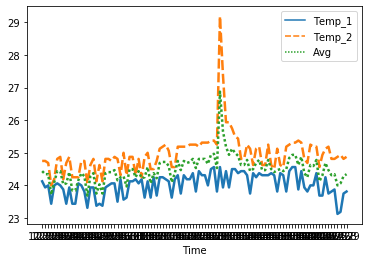

In [19]:
sns.lineplot(palette="tab10", linewidth=2.5,data=data_time)

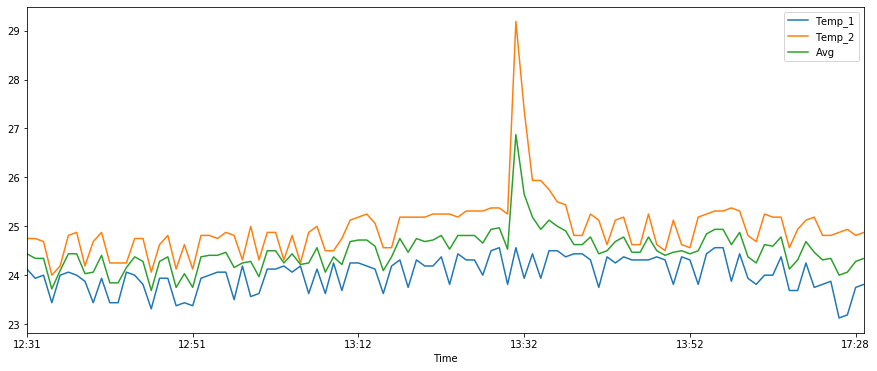

In [28]:
y = data_time['Avg']
data_time.plot(figsize=(15, 6))
plt.show()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
<a href = "https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b">LINK</a>

In [29]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

AttributeError: 'Index' object has no attribute 'inferred_freq'

In [ ]:
# let's modify a dataframe to hold the start time of the window and the end time 
# to hold our time stamps (for a particular average)
# mean of the 30 temperature along with the degree of freedom that we have and return the dataframe 
def moving_average(dataframe):
    win_start_time = collections.deque()
    win_end_time = collections.deque()
    avg = collections.deque()
    for iloc in range(0,len(dataframe.index.values),lag):
        win_start_time.append(dataframe.index.values[iloc:iloc+window].min())
        win_end_time.append(dataframe.index.values[iloc:iloc+window].max()) 
        sample = np.array(dataframe['Avg'].iloc[iloc:iloc+window].values, dtype=np.float64)
        avg.append(np.nanmean(sample))
    data = {'Start time' : list(win_start_time), 'End time': list(win_end_time), 'Average' : list(avg)}
    
    mov_avg_df = pd.DataFrame(data)
    return mov_avg_df 
mov_avg_df = moving_average(data_time) 
print(mov_avg_df)

In [85]:
data_time['MA_1']=data_time.Avg.rolling(window=20).mean()

In [78]:
data_time.head()

,Temp_1,Temp_2,Temp_3,Avg,MA_1
Time,,,,,
2019-07-19 12:08:00,24.125,24.375,24.687,24.395667,NaN
2019-07-19 12:09:00,24.562,24.875,24.375,24.604000,NaN
2019-07-19 12:10:00,24.750,25.250,25.250,25.083333,NaN
2019-07-19 12:12:00,24.687,24.750,25.125,24.854000,NaN
2019-07-19 12:13:00,24.250,23.563,24.188,24.000333,NaN


In [79]:
#plot correlation of temperatures with AVG

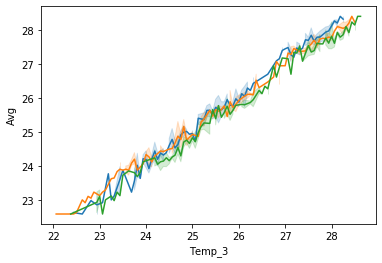

In [70]:
sns.lineplot(x="Temp_1", y="Avg",data=data_time)
sns.lineplot(x="Temp_2", y="Avg",data=data_time)
sns.lineplot(x="Temp_3", y="Avg",data=data_time)


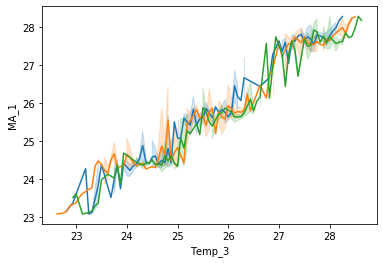

In [67]:
sns.lineplot(x="Temp_1", y="MA_1",data=data_time)
sns.lineplot(x="Temp_2", y="MA_1",data=data_time)
sns.lineplot(x="Temp_3", y="MA_1",data=data_time)


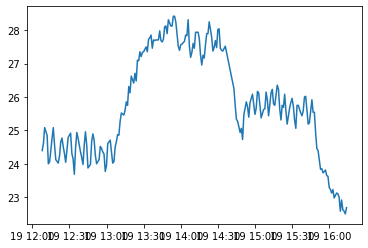

In [86]:
sns.lineplot(data=data_time['Avg'])

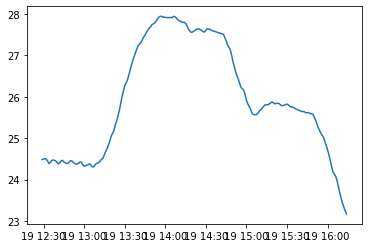

In [87]:
sns.lineplot(data=data_time['MA_1'])

In [88]:
from scipy.stats.stats import pearsonr 
data_time=data_time.dropna()
print (pearsonr(data_time['MA_1'], data_time['Avg']))

(0.8800909112060482, 5.391591762417557e-65)


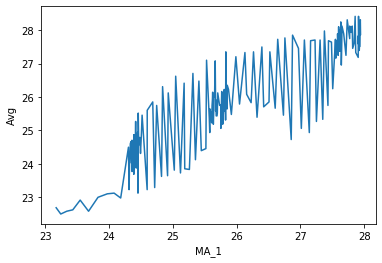

In [89]:
sns.lineplot(x="MA_1", y="Avg",data=data_time)

In [48]:
data_time.head()

,Temp_1,Temp_2,Temp_3,Avg,MA
Time,,,,,
2019-07-19 12:08:00,24.125,24.375,24.687,24.395667,NaN
2019-07-19 12:12:00,24.687,24.750,25.125,24.854000,NaN
2019-07-19 12:15:00,24.250,24.312,24.625,24.395667,24.548444
2019-07-19 12:18:00,24.562,24.062,25.062,24.562000,24.603889
2019-07-19 12:22:00,24.125,24.000,24.562,24.229000,24.395556


In [1]:
window = 3
lag = 1

            Start time            End time    Average
0  2019-07-18 16:00:00 2019-07-18 16:06:00  24.361000
1  2019-07-18 16:03:00 2019-07-18 16:10:00  24.423667
2  2019-07-18 16:06:00 2019-07-18 16:13:00  24.416556
3  2019-07-18 16:10:00 2019-07-18 16:16:00  24.326222
4  2019-07-18 16:13:00 2019-07-18 16:20:00  24.513556
5  2019-07-18 16:16:00 2019-07-18 16:23:00  24.367889
6  2019-07-18 16:20:00 2019-07-18 16:26:00  24.749778
7  2019-07-18 16:23:00 2019-07-18 16:29:00  24.583111
8  2019-07-18 16:26:00 2019-07-18 16:33:00  24.645444
9  2019-07-18 16:29:00 2019-07-18 16:36:00  24.485889
10 2019-07-18 16:33:00 2019-07-18 16:40:00  24.604000
11 2019-07-18 16:36:00 2019-07-18 16:43:00  24.652778
12 2019-07-18 16:40:00 2019-07-18 16:46:00  24.736111
13 2019-07-18 16:43:00 2019-07-18 16:50:00  24.708222
14 2019-07-18 16:46:00 2019-07-18 16:53:00  24.548556
15 2019-07-18 16:50:00 2019-07-18 16:56:00  24.541667
16 2019-07-18 16:53:00 2019-07-19 16:00:00  24.055667
17 2019-07-18 16:56:00 2019-